In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [9]:
img = cv2.imread('../images/coin2.png')


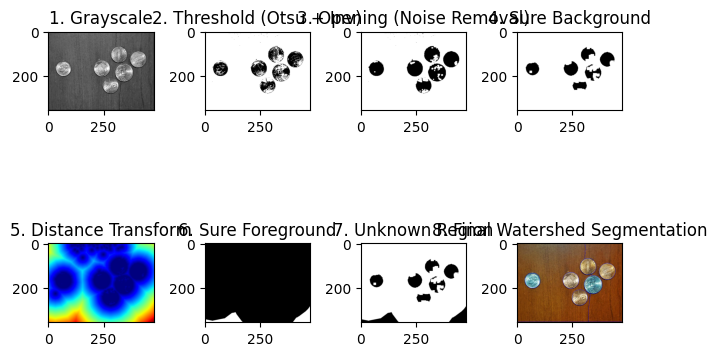

In [13]:
# 🎨 Step 1: Convert to Grayscale
# Why? Watershed operates on single-channel intensity maps
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.subplot(241), plt.imshow(gray, cmap='gray'), plt.title('1. Grayscale')

# 🧼 Step 2: Thresholding using Otsu's Method
# Inverse binary threshold + Otsu automatically chooses the best threshold
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.subplot(242), plt.imshow(thresh, cmap='gray'), plt.title('2. Threshold (Otsu + Inv)')

# 🧹 Step 3: Morphological Opening (Erosion followed by Dilation)
# Removes small white noise from thresholded image
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
plt.subplot(243), plt.imshow(opening, cmap='gray'), plt.title('3. Opening (Noise Removal)')

# 🌊 Step 4: Dilation to Get Sure Background
# Expands bright areas — ensures we cover the entire background
sure_bg = cv2.dilate(opening, kernel, iterations=3)
plt.subplot(244), plt.imshow(sure_bg, cmap='gray'), plt.title('4. Sure Background')

# 📏 Step 5: Distance Transform
# Computes the distance to the nearest zero pixel (background)
# Centers of objects have highest distance values
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.subplot(245), plt.imshow(dist_transform, cmap='jet'), plt.title('5. Distance Transform')

# 🎯 Step 6: Threshold Distance to Get Sure Foreground
# Pixels far enough from background are considered object centers
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
plt.subplot(246), plt.imshow(sure_fg, cmap='gray'), plt.title('6. Sure Foreground')

# 🚧 Step 7: Unknown Region (Boundary Area)
# Anything that's not clearly foreground or background is marked as unknown
unknown = cv2.subtract(sure_bg, sure_fg)
plt.subplot(247), plt.imshow(unknown, cmap='gray'), plt.title('7. Unknown Region')

# 🧭 Step 8: Marker Labelling
# Label connected components in the sure foreground
# Add +1 so background starts from 1 (0 will be reserved for unknown)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0  # Mark the unknown region as 0

# 💧 Step 9: Apply Watershed Algorithm
# It will flood the basins starting from marker seeds and stop at boundaries
markers = cv2.watershed(img, markers)

# 🖍️ Step 10: Mark boundaries in red on original image
# After watershed, boundary pixels are marked as -1
img_copy[markers == -1] = [255, 0, 0]  # Red color for boundaries

plt.subplot(248), plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title('8. Final Watershed Segmentation')

plt.tight_layout()
plt.show()